In [1]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import TransE
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

In [4]:
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [5]:
print(time.asctime())

Mon May 13 19:25:22 2019


In [6]:
print(pykeen.get_version())

0.0.26-dev


Check which hyper-parameters are required by TransE:

In [7]:
TransE.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'scoring_function',
 'normalization_of_entities']

Define output directory:

In [8]:
output_directory = os.path.join(
    os.path.expanduser('~'), 
    'Desktop', 
    'pykeen_test'
)

Define hyper-parameters:

Train TransE:

In [9]:
config = dict(
    random_seed                 = 0,
    embedding_dim               = 150,
    scoring_function            = 1,  # corresponds to L1
    normalization_of_entities   = 2,  # corresponds to L2
    margin_loss                 = 1,
    preferred_device            = 'gpu',
)

In [10]:
model = TransE(**config)

/home/lauve/.conda/envs/pykeen_horror/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [11]:
# Load data
train_triples = model.load_triples('../../tests/resources/data/rdf.nt')

In [12]:
losses = model.fit(train_triples, learning_rate=0.01, num_epochs=1000, batch_size=64)

INFO:pykeen.kge_models.base:****Run Model On CUDA****
Training epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.74it/s]
INFO:pykeen.kge_models.base:Training took 9 seconds 



Access trained model:

In [13]:
model

TransE(
  (criterion): MarginRankingLoss()
  (entity_embeddings): Embedding(89, 150)
  (relation_embeddings): Embedding(24, 150)
)

Visualize loss values:

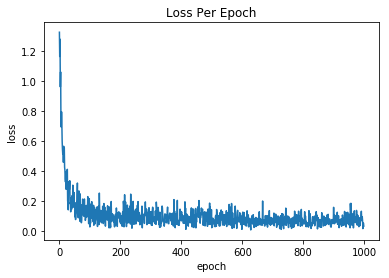

In [14]:
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

Move model to cpu

In [15]:
model._to_cpu()
model.eval()

TransE(
  (criterion): MarginRankingLoss()
  (entity_embeddings): Embedding(89, 150)
  (relation_embeddings): Embedding(24, 150)
)

Load test triples

In [16]:
test_triples = model.map_triples('../../tests/resources/data/rdf.nt')

Calculate results

In [17]:
from pykeen.utilities.evaluation_utils.metrics_computations import compute_metric_results

In [18]:
results = compute_metric_results(kg_embedding_model=model, mapped_train_triples=train_triples, 
                                mapped_test_triples=test_triples, device = model.device, filter_neg_triples=False)

⚽️ corrupting triples:   0%|          | 0/106 [00:00<?, ?it/s]/home/lauve/dataintegration/PyKEEN/src/pykeen/kge_models/trans_e.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  triples = torch.tensor(triples, dtype=torch.long, device=self.device)
⚽️ corrupting triples: 100%|██████████| 106/106 [00:00<00:00, 1126.38it/s]
INFO:pykeen.utilities.evaluation_utils.metrics_computations:Evaluation took 0.10s seconds


In [19]:
results

MetricResults(mean_rank=3.2264150943396226, hits_at_k={1: 0.27358490566037735, 3: 0.8254716981132075, 5: 0.8679245283018868, 10: 0.9198113207547169})

## Make subject and object predictions

In [20]:
subject = 'http://commons.dbpedia.org/resource/File:Paddestoel_003.jpg'
relation = 'http://commons.dbpedia.org/property/description'

In [21]:
model.predict_object(subject,relation)

'Paddestoel . These are used in the Netherlands to show directions for cyclists.'

In [22]:
obj = 'Paddestoel . These are used in the Netherlands to show directions for cyclists.'
relation = 'http://commons.dbpedia.org/property/description'

In [23]:
model.predict_subject(obj, relation)

'http://commons.dbpedia.org/resource/File:Paddestoel_003.jpg'